In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

In [37]:
data = pd.DataFrame(columns=['date', 'indice'])

diretorio = '../data/rl/'

arquivos_json = [arquivo for arquivo in os.listdir(diretorio) if arquivo.endswith('.json')]

for arquivo_json in arquivos_json:
    with open(os.path.join(diretorio, arquivo_json), 'r') as file:
        d = json.loads(file.read())
        
        data_temp = pd.DataFrame({
            'date': d['Indices']['NDVI']['Serie Processada']['Data'],
            'indice': d['Indices']['NDVI']['Serie Processada']['Indice']
        })

        data = pd.concat([data, data_temp], ignore_index=True)

/tmp/ipykernel_118671/730768136.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, data_temp], ignore_index=True)


In [38]:
data

,date,indice
0,2017-08-21,0.018645
1,2017-10-16,0.024464
2,2017-11-09,0.015563
3,2017-11-25,0.003720
4,2017-12-11,0.005570
...,...,...
131,2018-01-09,-0.055066
132,2018-01-25,0.114627
133,2018-03-14,0.653819
134,2018-05-25,0.022128


In [39]:
data.dtypes

date       object
indice    float64
dtype: object

In [40]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [41]:
data = data.set_index('date')
data = data.groupby(data.index).mean()
data = data.asfreq("M",method='backfill')
data = data.sort_index()
data.head(10)

,indice
date,
2017-07-31,0.009194
2017-08-31,0.000717
2017-09-30,0.018780
2017-10-31,0.000315
2017-11-30,0.017883
2017-12-31,0.088264
2018-01-31,0.011017
2018-02-28,0.008140
2018-03-31,0.007450


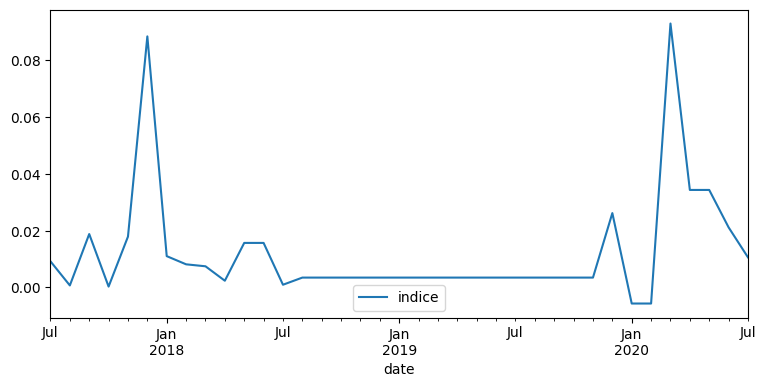

In [42]:
fig, ax = plt.subplots(figsize=(9, 4))
data['indice'].plot(ax=ax, label='indice')
ax.legend()

Model validation    